<a href="https://colab.research.google.com/github/No1-JSPARK/ANN_Proejct_Proposal/blob/main/Project%20Proposal_Source%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
os.chdir('/content/drive/MyDrive/Project1')

In [7]:
!pwd

/content/drive/MyDrive/Project1


In [8]:
train_data=pd.read_csv('./sign_mnist_train.csv')
test_data=pd.read_csv('./sign_mnist_test.csv')

In [9]:
print(train_data.shape, test_data.shape)

(27455, 785) (7172, 785)


In [10]:
train_data.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195


In [11]:
device = torch.device('cuda:0')

In [12]:
class mnist_dataset(Dataset):

    def __init__(self, df):
      self.inp = df.iloc[:,1:].values.reshape(df.shape[0],28,28)
      self.outp = df.iloc[:,0].values.reshape(df.shape[0],1)
    
    def __len__(self):
      return len(self.inp)
    
    def __getitem__(self,idx):
      inp=torch.FloatTensor(self.inp[idx]).unsqueeze(0).to(device)
      outp=torch.LongTensor(self.outp[idx]).squeeze().to(device)
      return inp, outp

In [13]:
train, valid = train_test_split(train_data, test_size=0.2)
batch_size = 128
valid_dl = DataLoader(mnist_dataset(valid),batch_size, shuffle=False)
train_dl = DataLoader(mnist_dataset(train),batch_size, shuffle=True)

x,y=next(iter(train_dl))
print(x.cpu().numpy().shape, y.cpu().numpy().shape)
y[0]

(128, 1, 28, 28) (128,)


tensor(10, device='cuda:0')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


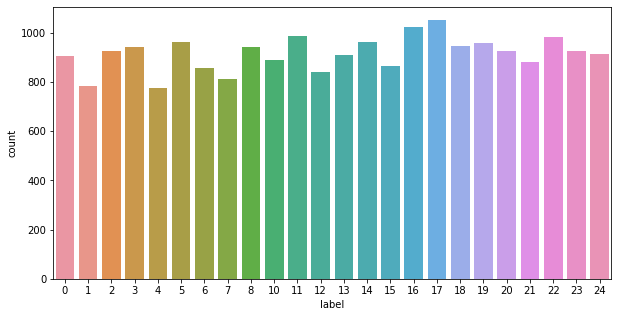

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(train["label"])
plt.show()

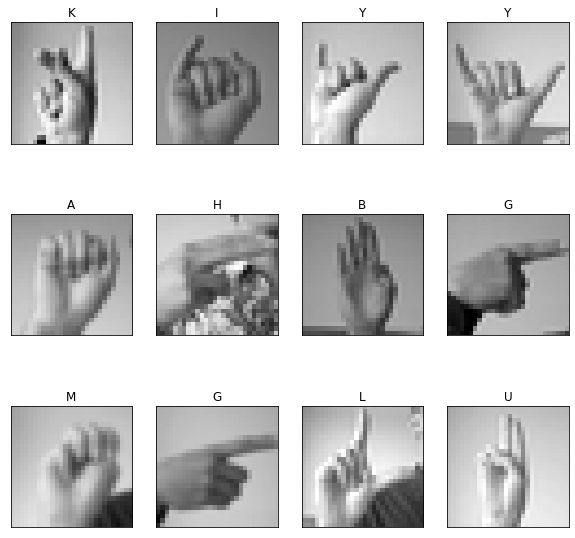

In [15]:
fig=plt.figure(figsize=(10,10),)

for i in range(1,13):
  img=train.iloc[i,1:]
  label=train.iloc[i,0]
  img=img.values.reshape(28,28)
  ax = fig.add_subplot(3,4,i)
  ax.set_title(chr(65+label))
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [16]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))      


model.add_module('flatten', nn.Flatten()) 


model.add_module('fc1', nn.Linear(3136, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 
model.add_module('fc2', nn.Linear(1024, 25))

In [17]:
model = model.to(device)

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train(model, num_epochs, train_dl, valid_dl):
    
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        
        model.train()
        
        for x_batch, y_batch in train_dl:
            
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 100
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.4519 val_accuracy: 0.8794
Epoch 2 accuracy: 0.8795 val_accuracy: 0.9885
Epoch 3 accuracy: 0.9692 val_accuracy: 0.9989
Epoch 4 accuracy: 0.9915 val_accuracy: 0.9998
Epoch 5 accuracy: 0.9949 val_accuracy: 1.0000
Epoch 6 accuracy: 0.9979 val_accuracy: 1.0000
Epoch 7 accuracy: 0.9989 val_accuracy: 1.0000
Epoch 8 accuracy: 0.9991 val_accuracy: 1.0000
Epoch 9 accuracy: 0.9988 val_accuracy: 1.0000
Epoch 10 accuracy: 0.9985 val_accuracy: 1.0000
Epoch 11 accuracy: 0.9996 val_accuracy: 1.0000
Epoch 12 accuracy: 0.9995 val_accuracy: 1.0000
Epoch 13 accuracy: 0.9993 val_accuracy: 1.0000
Epoch 14 accuracy: 0.9995 val_accuracy: 1.0000
Epoch 15 accuracy: 0.9985 val_accuracy: 1.0000
Epoch 16 accuracy: 0.9995 val_accuracy: 1.0000
Epoch 17 accuracy: 0.9992 val_accuracy: 1.0000
Epoch 18 accuracy: 0.9984 val_accuracy: 0.9993
Epoch 19 accuracy: 0.9976 val_accuracy: 1.0000
Epoch 20 accuracy: 0.9996 val_accuracy: 0.9996
Epoch 21 accuracy: 0.9972 val_accuracy: 1.0000
Epoch 22 accuracy: 0.9

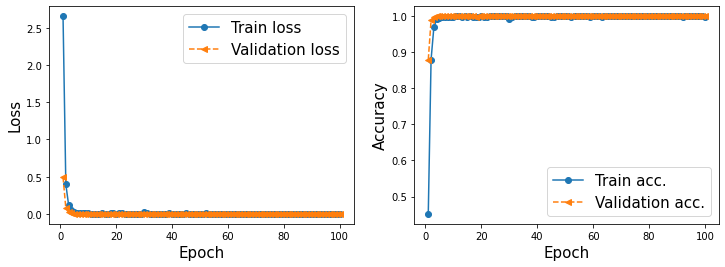

In [19]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

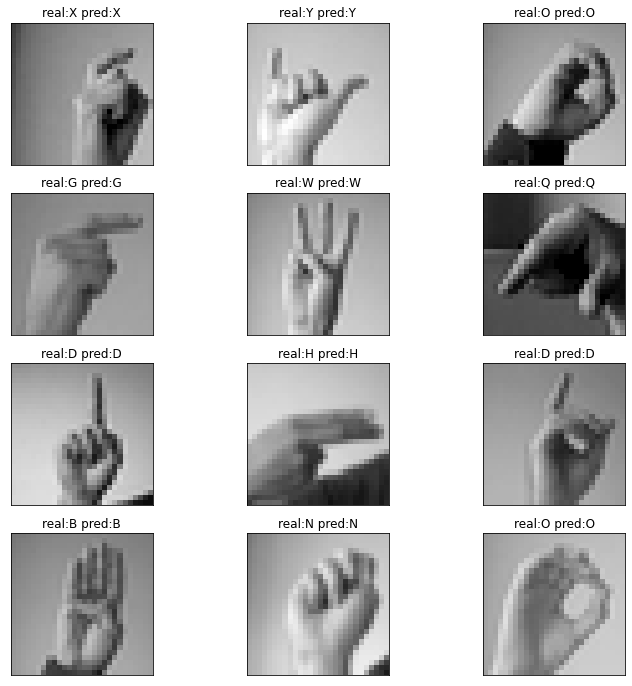

In [20]:
test_dl = DataLoader(mnist_dataset(test_data),shuffle=True)

fig = plt.figure(figsize=(12,12))
for i in range(1,13):
    data, real_label = next(iter(test_dl))
    pred = model(data)
    pred_label = np.argmax(pred.cpu().detach().numpy())
    img = data.cpu().numpy().reshape(28,28)
    ax = fig.add_subplot(4, 3, i)
    ax.set_title("real:"+chr(65+real_label)+" pred:"+chr(65+pred_label))
    ax.set_xticks([]); ax.set_yticks([])
    plt.imshow(img, cmap='gray',vmin=0,vmax=255)
plt.show()